In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

In [ ]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

In [ ]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
config.model.n_layers_per_subdec = 7
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

In [ ]:
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

In [ ]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

In [ ]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

import sys
sys.path.append('/path/to/project')

import utils.plotting.HighLevelFeatures as HLF
import h5py
from ipynb.fs.full.utils.plotting.HEPMetrics import get_fpd_kpd_metrics

In [ ]:
def search_HEPMetric(path_head, model_name, start_epoch, end_epoch, epoch_int):
    en_list = []
    fpd_recon, fpd_sample = [], []
    kpd_recon, kpd_sample = [], []
    hlf, ref_hlf = None, None
    for en in range(start_epoch, end_epoch, epoch_int):
        run_path = path_head + str(en) + ".pth"
        modelname = model_name
        datascaled = 'reduced'
        open_path = path_head.replace(path_head.split('/')[-1], '') + "config.yaml"
        with open(open_path, 'r') as file:
            model_config = yaml.safe_load(file)
            R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
            reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
            scaled=False
            
        arch = config['model']['model_type']
        part = config['data']['particle_type']
        modelCreator.load_state(run_path, dev)
        engine.model.eval();

        # get the samples
        xtarget_samples = []
        xrecon_samples = []
        xgen_samples = []
        xgen_samples_qpu = []
        n_samples4_qpu = 200
        
        # xrecon_samples_2 = []
        
        # labelstarget_samples = []
        # labelsrecon_samples = []
        entarget_samples = []
        with torch.no_grad():
            for xx in train_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in val_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in test_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)
        
        # xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)
        if en == start_epoch:
            print("First epoch")
            hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            ref_hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            hlf.Einc = entarget_samples

        recon_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
        sample_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xgen_samples), False, hlf, ref_hlf)

        en_list.append(en)
        fpd_recon.append(recon_HEPMetrics[0])
        kpd_recon.append(recon_HEPMetrics[2])
        fpd_sample.append(sample_HEPMetrics[0])
        kpd_sample.append(sample_HEPMetrics[2])
        print("Finished generating HEP Metrics for epoch " + str(en) + " ...")
    return en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample

In [20]:
path_head = "/fast_scratch_1/caloqvae/luian1/wandb/run-20250315_231215-nt1vh19r/files/AtlasConditionalQVAE3DHD_atlas_default_"
model_name = 'ethereal-meadow-666'
HEPMetric_output = search_HEPMetric(path_head, model_name, 180, 181, 10)

[05:22:52.276] INFO   models.modelCreator                               Loading state
[05:22:52.745] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250315_231215-nt1vh19r/files/AtlasConditionalQVAE3DHD_atlas_default_180.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
First epoch
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 103.2901 ± 1.1772
KPD (x10^3): 0.3282 ± 0.1146
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 288.2933 ± 1.2746
KPD (x10^3): 0.4010 ± 0.0308
Finished generating HEP Metrics for epoch 180 ...


[0.3443265982956043, 0.2807222047910817, 0.2757433748913746, 0.29571222905017613, 0.2278632655323166, 0.26728961075753005, 0.21457047342215926, 0.19076019788270482, 0.17268513518050777, 0.18269869509509043, 0.1545314802788361, 0.14377719499377623, 0.13184473037980288, 0.1161674663316766, 0.11235210918332428, 0.12750423816174697, 0.12426023045640053, 0.10207775511239257, 0.09785014107937617, 0.09259484425299055] [0.0011395584132993797, 0.001453290601438173, 0.0010401016171155408, 0.0017396070321622492, 0.0007496637932626893, 0.0012715529948765791, 0.0010609646450225885, 0.000769021391776592, 0.0005004954434659759, 0.0006710932600113573, 0.0007814343709844351, 0.0006392766888265733, 0.0003707799674825818, 0.00040130424773021645, 0.0004270382691247132, 0.000501783952513879, 0.0004979863523311145, 0.00045454841278558256, 0.00030436200676864367, 0.0003427283393580005] [0.5257284124938946, 0.4124494803636761, 0.42818361024676516, 0.46936289865785424, 0.3590682192069662, 0.4327680558783181, 0

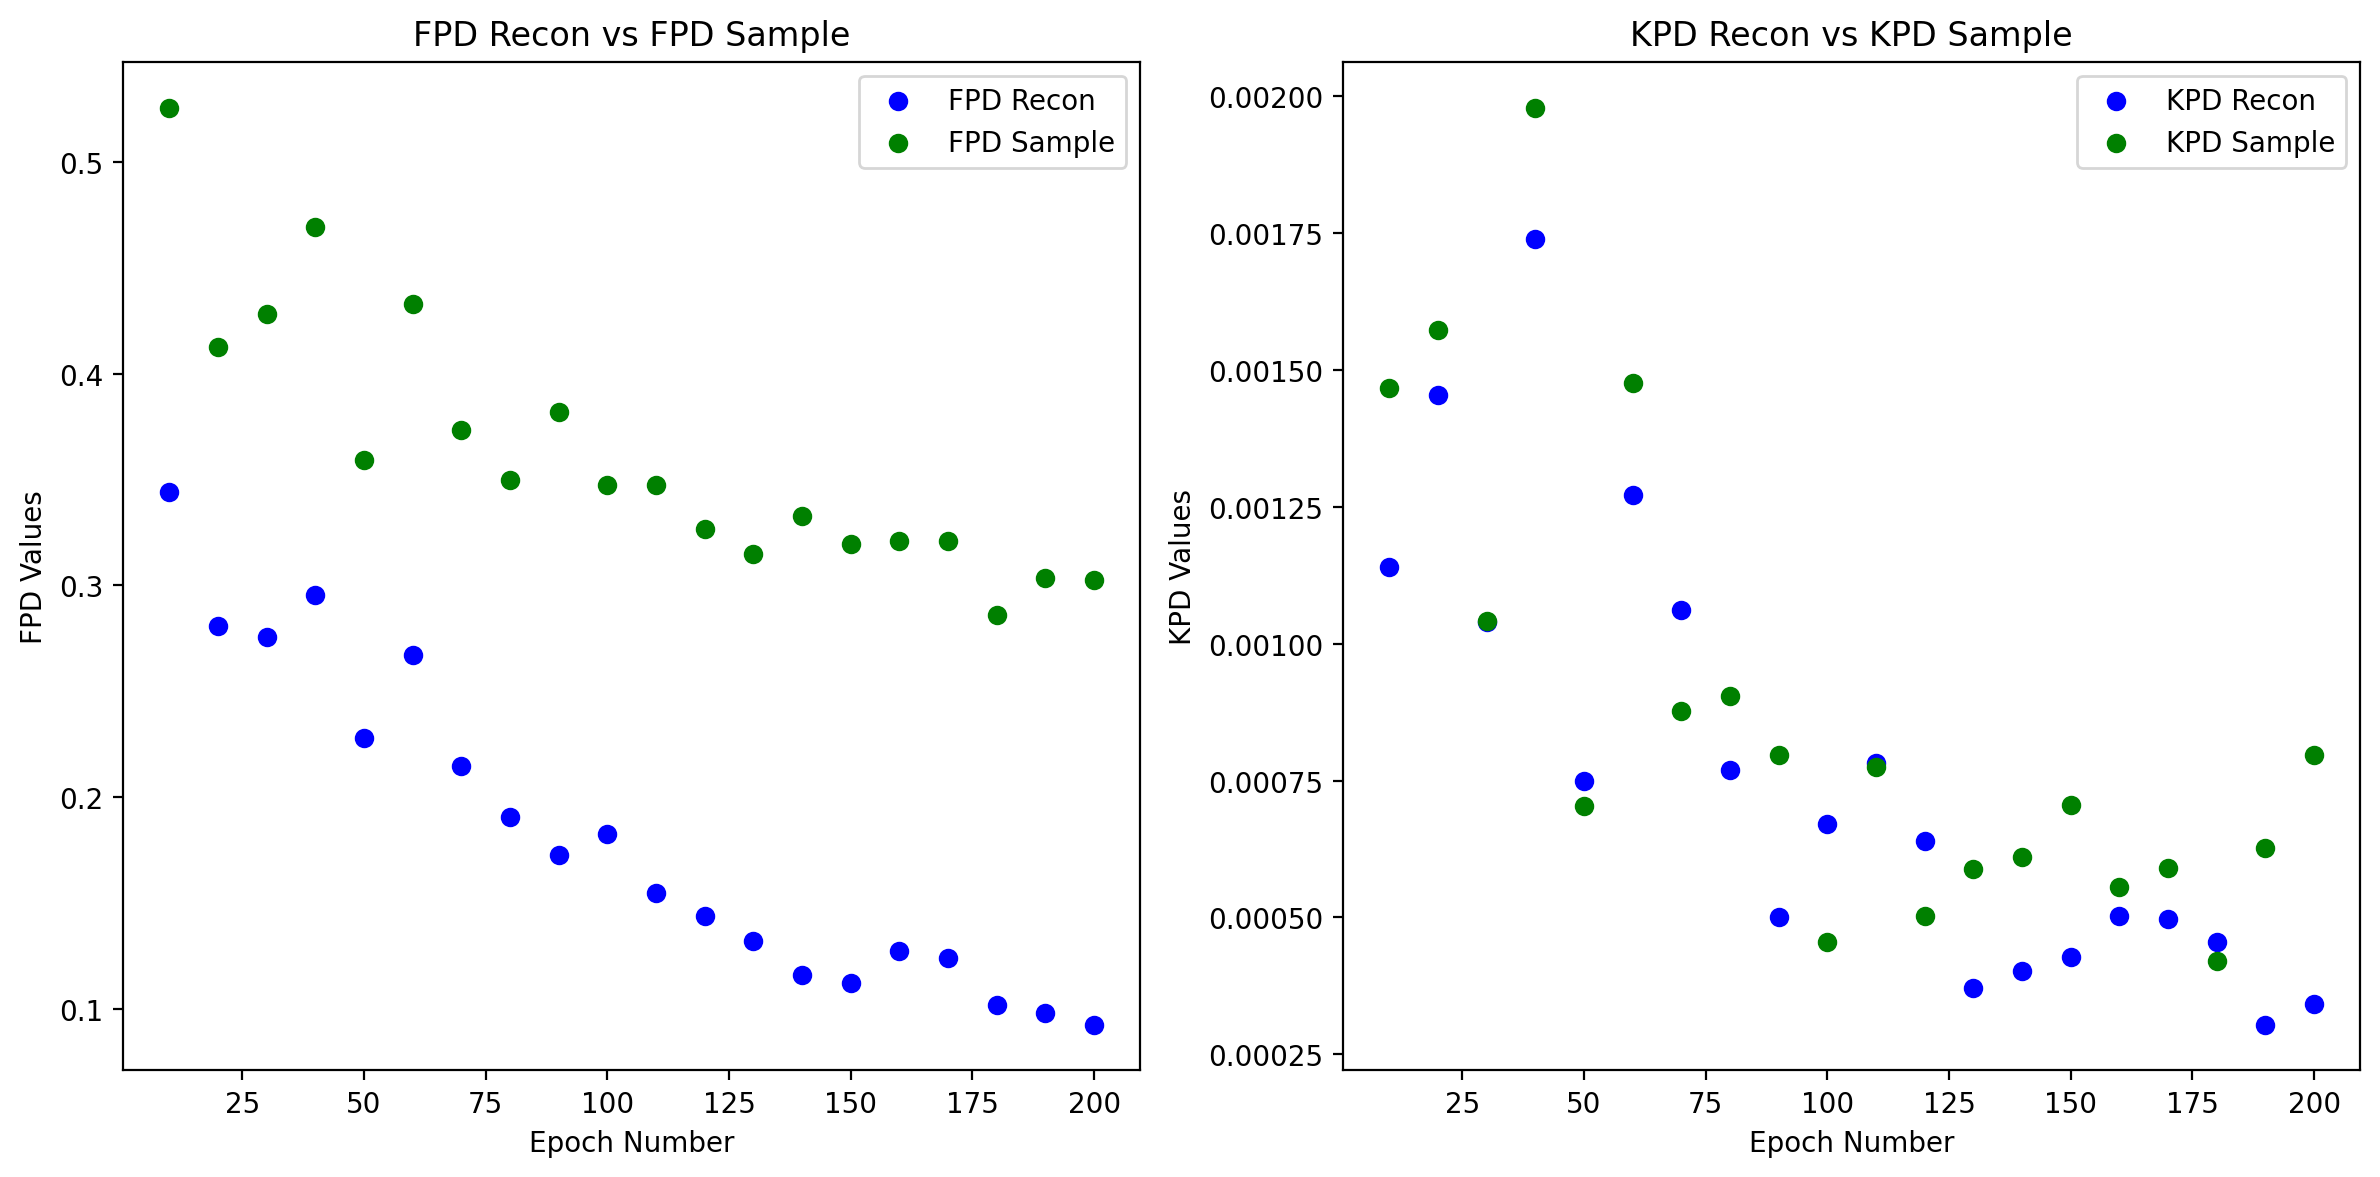

In [18]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon, color='blue', label='FPD Recon')
ax1.scatter(en_list, fpd_sample, color='green', label='FPD Sample')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon, color='blue', label='KPD Recon')
ax2.scatter(en_list, kpd_sample, color='green', label='KPD Sample')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
print(min(fpd_recon), min(kpd_recon), min(fpd_sample), min(kpd_sample))

0.09259484425299055 0.00030436200676864367 0.28616358397778946 0.0004207202158397205
